In [1]:
!kaggle datasets download -d yasserhessein/gender-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/gender-dataset
License(s): unknown
100% 1.32G/1.32G [01:22<00:00, 22.6MB/s]
100% 1.32G/1.32G [01:22<00:00, 17.2MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gender-dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [49]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [50]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [51]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [52]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/content/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )

validation_generator =  test_datagen.flow_from_directory( '/content/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [7]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 4s 0us/step


In [53]:

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [54]:
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.3))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.3))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.3))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.3))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.3))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.5))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.5))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.5))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout_48 (Dropout)        (None, 2, 2, 512)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 2, 2, 512)         2359808   
                                                                 
 conv2d_37 (Conv2D)          (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization_30 (Ba  (None, 2, 2, 512)         2048      
 tchNormalization)                                               
                                                                 
 dropout_49 (Dropout)        (None, 2, 2, 512)         0         
                                                      

In [55]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

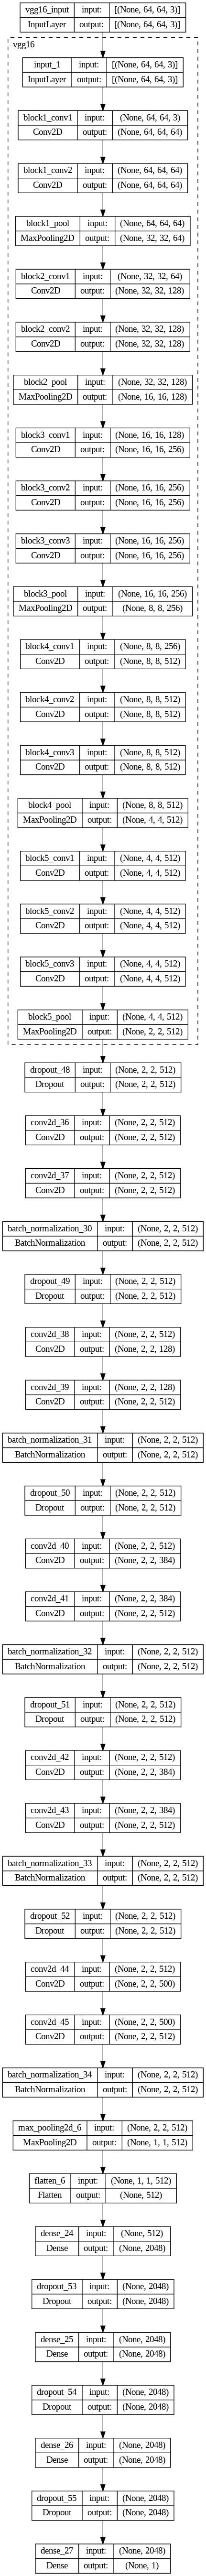

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


In [57]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [58]:
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

Epoch 1/8


<ipython-input-58-825b58d6e104>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


256/256 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9245

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - 78s 260ms/step - loss: 0.2316 - accuracy: 0.9245 - val_loss: 0.3191 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 62s 242ms/step - loss: 0.1828 - accuracy: 0.9319 - val_loss: 0.1724 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 61s 238ms/step - loss: 0.1675 - accuracy: 0.9384 - val_loss: 0.1366 - val_accuracy: 0.9564 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 68s 267ms/step - loss: 0.2716 - accuracy: 0.9005 - val_loss: 0.6148 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - 60s 232ms/step - loss: 0.1824 - accuracy: 0.9384 - val_loss: 0.1093 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 6/8
256/256 [==============================] - 58s 225ms/step - loss: 0.1431 - accuracy: 0.9477 - val_loss: 0.1006 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 7/8
256/256 [==============================] - 67s 261ms/step 

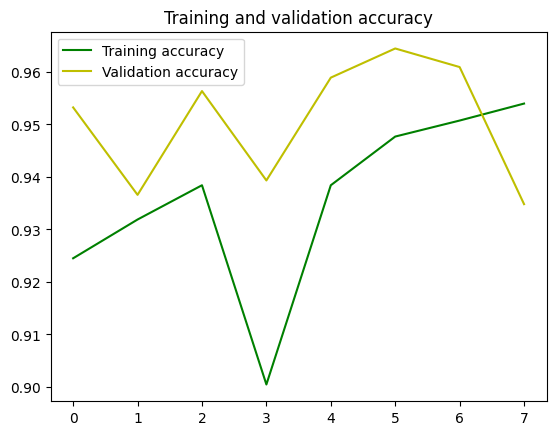

<Figure size 640x480 with 0 Axes>

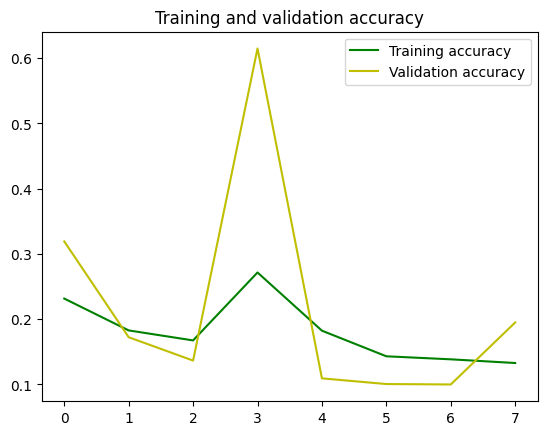

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

epochs = range(len(loss))
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [61]:
model.save('gender_classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step
[0.18917997]
This is a male
1/1 [==============================] - 0s 17ms/step
[0.6341741]
This  is a female
1/1 [==============================] - 0s 19ms/step
[0.9992706]
This  is a female
1/1 [==============================] - 0s 17ms/step
[0.01458476]
This is a male
1/1 [==============================] - 0s 16ms/step
[0.9999982]
This  is a female


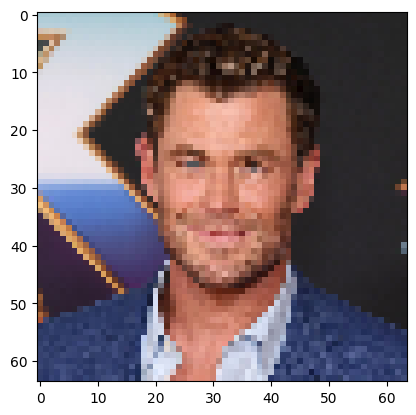

In [69]:
import numpy as np

from keras.preprocessing import image
for i in range (1,6):
  path_testmodel = f"/content/images{i}.jpeg"
  imge = image.load_img(path_testmodel, target_size=target_size)
  X = image.img_to_array(imge)
  X = np.expand_dims(X, axis=0)
  X/= 255.0
  images = np.vstack([X])
  classes = model.predict(images, batch_size=1)
  print(classes[0])
  if classes[0]<0.5:
      print("This is a male")
  else:
      print( "This  is a female")
  plt.imshow(imge)

In [1]:
import tensorflow as tf
print(tf.__version__)


2.15.0
